**Shoe Data**

In [2]:
# Welcome to your new notebook
# Type here in the cell editor to add code!
data = spark.read.format("delta").load("Tables/shoedata")
SEED = 1234
df = data.toPandas()
df.drop(['ShoeSizeUS'],axis=1,inplace=True)
df.info()

StatementMeta(, 9d8a7c04-d3d0-4663-9b2d-e125f1033698, 4, Finished, Available, Finished)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Gender      100000 non-null  object 
 1   Age         100000 non-null  float64
 2   Height      100000 non-null  float64
 3   Weight      100000 non-null  float64
 4   ShoeSizeUK  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


StatementMeta(, 9d8a7c04-d3d0-4663-9b2d-e125f1033698, 5, Finished, Available, Finished)

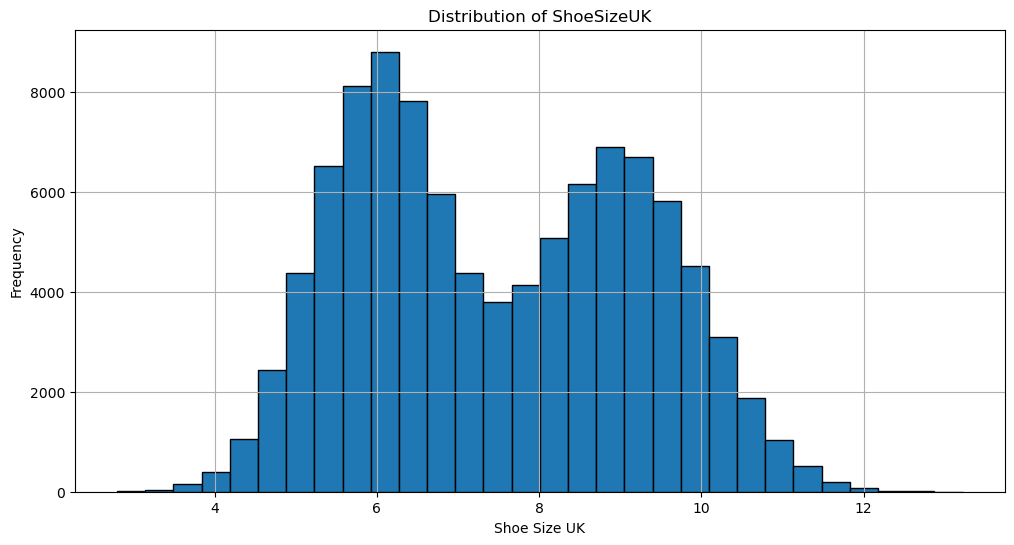

ShoeSizeUK
2.796527     1
2.948636     1
3.000898     1
3.037087     1
3.074159     1
            ..
12.739199    1
12.766180    1
12.826255    1
12.827565    1
13.219366    1
Name: count, Length: 99998, dtype: int64

In [3]:
import matplotlib.pyplot as plt

# Inspect the target variable "ShoeSizeUK" for class imbalance
target_variable = 'ShoeSizeUK'

# Plot the distribution of the target variable
plt.figure(figsize=(12, 6))
df[target_variable].hist(bins=30, edgecolor='black')
plt.title('Distribution of ShoeSizeUK')
plt.xlabel('Shoe Size UK')
plt.ylabel('Frequency')
plt.show()

# Check for class imbalance by looking at the value counts
class_distribution = df[target_variable].value_counts().sort_index()
class_distribution


In [4]:
# Map Gender to numerical values 
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

StatementMeta(, 9d8a7c04-d3d0-4663-9b2d-e125f1033698, 6, Finished, Available, Finished)

StatementMeta(, 9d8a7c04-d3d0-4663-9b2d-e125f1033698, 7, Finished, Available, Finished)

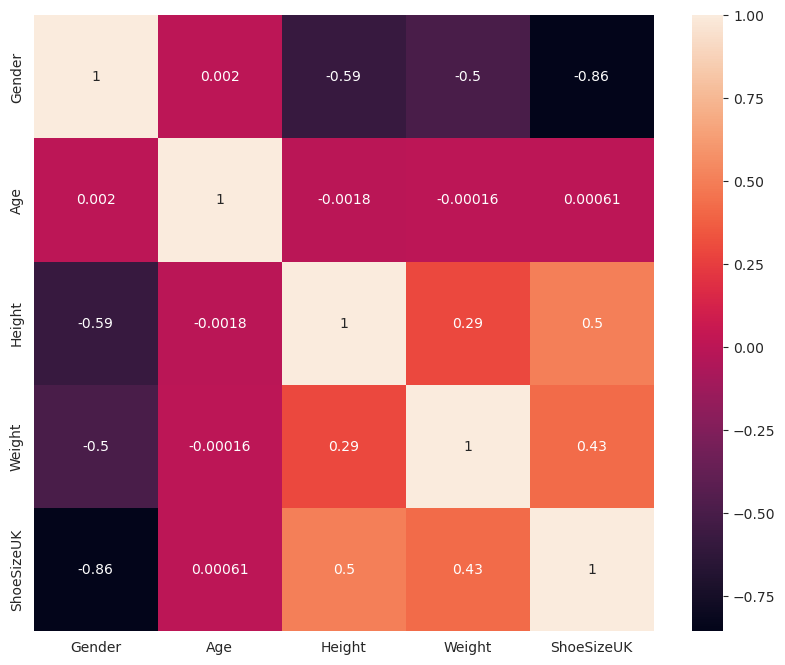

In [5]:
# Import packages and set plotting style
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
sns.set_style('darkgrid')

# Create the correlation matrix
corr_matrix = df.corr(numeric_only=True)

# Plot a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [8]:
import numpy as np 
from sklearn.ensemble import RandomForestRegressor
from mlflow.models.signature import infer_signature
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import mlflow

# Assume `shoe_data` has been loaded and preprocessed as before
# shoe_data = spark.read.format("delta").load("/path/to/fabric/lakehouse/tables/ShoeData").toPandas()
# shoe_data = shoe_data.drop(columns=['ShoeSizeUS'])

# Define features and target
features = df.drop(columns=['ShoeSizeUK'])
target = df['ShoeSizeUK']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

mlflow.set_experiment("ShoeSize_Regression")
mlflow.autolog(exclusive=False)  # Override the pre-configured autologging behavior

with mlflow.start_run() as run:
    rfr_id = run.info.run_id
    print(f"run_id {rfr_id}, status: {run.info.status}")
    rfr = RandomForestRegressor(max_depth=5, n_estimators=50, random_state=42)
    rfr.fit(X_train, y_train) 
    signature = infer_signature(X_train, y_train)

    mlflow.sklearn.log_model(
        rfr,
        "shoe_size_model_rf",
        signature=signature,
        registered_model_name="shoe_size_model_rf"
    ) 

    y_pred_train = rfr.predict(X_train)
    # Calculate the regression metrics for train data
    mae_train = mean_absolute_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)

    # Log the regression metrics to MLflow
    mlflow.log_metric("mae_train", mae_train)
    mlflow.log_metric("r2_train", r2_train)

    # Print the run ID and the regression metrics
    print("MAE_train:", mae_train)
    print("R2_train:", r2_train)    

    y_pred_test = rfr.predict(X_test)
    # Calculate the regression metrics for test data
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)

    # Log the regression metrics to MLflow
    mlflow.log_metric("mae_test", mae_test)
    mlflow.log_metric("r2_test", r2_test)

    # Print the regression metrics
    print("MAE_test:", mae_test)
    print("R2_test:", r2_test)


StatementMeta(, 9d8a7c04-d3d0-4663-9b2d-e125f1033698, 10, Finished, Available, Finished)

2024/07/07 21:04:58 INFO mlflow.tracking.fluent: Experiment with name 'ShoeSize_Regression' does not exist. Creating a new experiment.
2024/07/07 21:05:06 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/07/07 21:05:06 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2024/07/07 21:05:07 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as d

run_id 6ba25c11-2e2d-4b5b-9f0a-3d0a5b6a3e17, status: RUNNING
MAE_train: 0.715691398664387
R2_train: 0.733496779642782
MAE_test: 0.720597964922075
R2_test: 0.7314728638976691


In [9]:
from sklearn.linear_model import LinearRegression


with mlflow.start_run() as run:
    lr_id = run.info.run_id
    print(f"run_id {lr_id}, status: {run.info.status}")
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    signature = infer_signature(X_train, y_train)

    mlflow.sklearn.log_model(
        lr,
        "shoe_size_model_lr",
        signature=signature,
        registered_model_name="shoe_size_model_lr"
    )

    y_pred_train = lr.predict(X_train)
    # Calculate the regression metrics for train data
    mae_train = mean_absolute_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)

    # Log the regression metrics to MLflow
    mlflow.log_metric("mae_train", mae_train)
    mlflow.log_metric("r2_train", r2_train)

    # Print the run ID and the regression metrics
    print("MAE_train:", mae_train)
    print("R2_train:", r2_train)

    y_pred_test = lr.predict(X_test)
    # Calculate the regression metrics for test data
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)

    # Log the regression metrics to MLflow
    mlflow.log_metric("mae_test", mae_test)
    mlflow.log_metric("r2_test", r2_test)

    # Print the regression metrics
    print("MAE_test:", mae_test)
    print("R2_test:", r2_test)


StatementMeta(, 9d8a7c04-d3d0-4663-9b2d-e125f1033698, 11, Finished, Available, Finished)

2024/07/07 21:06:53 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024-07-07:21:06:53,827 WARNING  [tracking_store.py:153] log_inputs not supported
2024/07/07 21:06:54 WARNING mlf

run_id f25f9985-2f77-49d0-8ae5-119d6669aa61, status: RUNNING
MAE_train: 0.7169639760568934
R2_train: 0.7324650753464295
MAE_test: 0.7202507888065617
R2_test: 0.7317028125479128


In [10]:
import xgboost as xgb

with mlflow.start_run() as run:
    xgb_id = run.info.run_id
    print(f"run_id {xgb_id}, status: {run.info.status}")
    
    xgboost_model = xgb.XGBRegressor()
    xgboost_model.fit(X_train, y_train)
    signature = infer_signature(X_train, y_train)

    mlflow.sklearn.log_model(
        xgboost_model,
        "shoe_size_model_xgb",
        signature=signature,
        registered_model_name="shoe_size_model_xgb"
    )

    y_pred_train = xgboost_model.predict(X_train)
    # Calculate the regression metrics for train data
    mae_train = mean_absolute_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)

    # Log the regression metrics to MLflow
    mlflow.log_metric("mae_train", mae_train)
    mlflow.log_metric("r2_train", r2_train)

    # Print the run ID and the regression metrics
    print("MAE_train:", mae_train)
    print("R2_train:", r2_train)

    y_pred_test = xgboost_model.predict(X_test)
    # Calculate the regression metrics for test data
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)

    # Log the regression metrics to MLflow
    mlflow.log_metric("mae_test", mae_test)
    mlflow.log_metric("r2_test", r2_test)

    # Print the regression metrics
    print("MAE_test:", mae_test)
    print("R2_test:", r2_test)


StatementMeta(, 9d8a7c04-d3d0-4663-9b2d-e125f1033698, 12, Finished, Available, Finished)

2024/07/07 21:09:44 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2024-07-07:21:09:45,363 WARNING  [tracking_store.py:153] log_inputs not supported
2024/07/07 21:09:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/mlflow/models/signature.py:214: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html

run_id 88162926-c5d8-4937-a344-2afb37fb9654, status: RUNNING
MAE_train: 0.6840649866089678
R2_train: 0.7555462454879474
MAE_test: 0.7262608583225049
R2_test: 0.7273047054298323


In [12]:
runs = {'random forest classifer':   rfr_id,
        'logistic regression classifier': lr_id,
        'xgboost classifier': xgb_id}

# Create an empty list to hold the metrics
df_metrics = []

# Loop through the run IDs and retrieve the metrics for each run
for run_name, run_id in runs.items():
    metrics = mlflow.get_run(run_id).data.metrics
    metrics["run_name"] = run_name
    df_metrics.append(metrics)

# Convert the list to DataFrame
df_metrics = pd.DataFrame(df_metrics)

# Print the DataFrame
print(df_metrics)

StatementMeta(, 9d8a7c04-d3d0-4663-9b2d-e125f1033698, 14, Finished, Available, Finished)

   training_mean_squared_error  training_root_mean_squared_error  \
0                     0.815352                          0.902968   
1                     0.818508                          0.904714   
2                          NaN                               NaN   

   training_mean_absolute_error  training_score  training_r2_score  \
0                      0.715691        0.733497           0.733497   
1                      0.716964        0.732465           0.732465   
2                           NaN             NaN                NaN   

   mean_absolute_error_X_train  r2_score_X_train  mae_train  r2_train  \
0                     0.715691          0.733497   0.715691  0.733497   
1                     0.716964          0.732465   0.716964  0.732465   
2                     0.684065          0.755546   0.684065  0.755546   

   mean_absolute_error-2_X_test  r2_score-2_X_test  mae_test   r2_test  \
0                      0.720598           0.731473  0.720598  0.731473   
1    

In [13]:
df.head()

StatementMeta(, 9d8a7c04-d3d0-4663-9b2d-e125f1033698, 15, Finished, Available, Finished)

,Gender,Age,Height,Weight,ShoeSizeUK
0,0,18.881199,178.189022,81.348496,10.010515
1,0,20.919759,160.876963,95.587785,8.774224
2,0,55.594880,178.942330,79.466630,8.484564
3,0,23.993613,172.083063,70.779521,10.852278
4,0,24.663512,174.944721,75.246595,9.389349


In [14]:
df_metrics.head()

StatementMeta(, 9d8a7c04-d3d0-4663-9b2d-e125f1033698, 16, Finished, Available, Finished)

,training_mean_squared_error,training_root_mean_squared_error,training_mean_absolute_error,training_score,training_r2_score,mean_absolute_error_X_train,r2_score_X_train,mae_train,r2_train,mean_absolute_error-2_X_test,r2_score-2_X_test,mae_test,r2_test,run_name
0,0.815352,0.902968,0.715691,0.733497,0.733497,0.715691,0.733497,0.715691,0.733497,0.720598,0.731473,0.720598,0.731473,random forest classifer
1,0.818508,0.904714,0.716964,0.732465,0.732465,0.716964,0.732465,0.716964,0.732465,0.720251,0.731703,0.720251,0.731703,logistic regression classifier
2,NaN,NaN,NaN,NaN,NaN,0.684065,0.755546,0.684065,0.755546,0.726261,0.727305,0.726261,0.727305,xgboost classifier


In [16]:
from synapse.ml.predict import MLFlowTransformer

model = MLFlowTransformer(
    inputCols=list(X_test.columns),
    outputCol='predictions',
    modelName='shoe_size_model_lr',
    modelVersion=1
)

StatementMeta(, 9d8a7c04-d3d0-4663-9b2d-e125f1033698, 18, Finished, Available, Finished)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/functions.py:399: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.


StatementMeta(, 9d8a7c04-d3d0-4663-9b2d-e125f1033698, 19, Finished, Available, Finished)

StatementMeta(, 9d8a7c04-d3d0-4663-9b2d-e125f1033698, 20, Finished, Available, Finished)

In [17]:
predictions = model.transform(spark.createDataFrame(X_test))
predictions.show()

StatementMeta(, 9d8a7c04-d3d0-4663-9b2d-e125f1033698, 21, Finished, Available, Finished)

+------+-----------+-----------+-----------+------------------+
|Gender|        Age|     Height|     Weight|       predictions|
+------+-----------+-----------+-----------+------------------+
|     1|37.46352369|155.3533061|66.81275222| 6.008467578436134|
|     1|37.76443697|165.3883553|50.83453416|6.0053636216281046|
|     0|41.24271315|181.6348372| 76.3384694| 8.999281184422493|
|     1|21.89524654|156.7469824|66.74813866| 6.001577916895564|
|     1|27.63255682|170.8982247|42.25772944| 5.999430636903021|
|     1|32.29740598|149.9534771|70.49749893| 6.008212143780533|
|     1|50.61886219|160.5845822|68.48811402|6.0119226618438475|
|     1|28.52502801|162.9007646|56.34544795| 6.002333800863285|
|     1|23.74409744|176.0527458|75.85738168| 5.995097674058764|
|     1|35.32377528|180.5599362|63.39867714|5.9985343302775975|
|     0|23.80699047|194.9458621|67.50451262| 8.987529071834679|
|     0|32.73180496|167.6693194| 64.8496769| 9.001153089438864|
|     0|41.50769685|169.5215525|88.87294

In [18]:
# Save test data to lakehouse for use in future
table_name = "ShoeDataTestPrediction"
predictions.write.mode("overwrite").format("delta").save(f"Tables/{table_name}")
print(f"Spark dataframe saved to delta table: {table_name}")

StatementMeta(, 9d8a7c04-d3d0-4663-9b2d-e125f1033698, 22, Finished, Available, Finished)

Spark dataframe saved to delta table: ShoeDataTestPrediction


In [21]:
submissionid = "adjhdg"
Gender_value = 1
Age_value = 31.0
Height_value = .0
Weight_value = 71.0

StatementMeta(, 9d8a7c04-d3d0-4663-9b2d-e125f1033698, 27, Finished, Available, Finished)

In [22]:
from synapse.ml.predict import MLFlowTransformer

model = MLFlowTransformer(
    inputCols=['Gender', 'Age', 'Height', 'Weight'],
    outputCol='predictions',
    modelName='shoe_size_model_lr',
    modelVersion=1)

newtest = pd.DataFrame([[Gender_value, Age_value, Height_value, Weight_value]],
                       columns=['Gender', 'Age', 'Height','Weight'])
predictions = model.transform(spark.createDataFrame(newtest))

StatementMeta(, 9d8a7c04-d3d0-4663-9b2d-e125f1033698, 28, Finished, Available, Finished)

StatementMeta(, 9d8a7c04-d3d0-4663-9b2d-e125f1033698, 29, Finished, Available, Finished)

StatementMeta(, 9d8a7c04-d3d0-4663-9b2d-e125f1033698, 30, Finished, Available, Finished)

In [23]:
predictions.show()

StatementMeta(, 9d8a7c04-d3d0-4663-9b2d-e125f1033698, 31, Finished, Available, Finished)

+------+----+------+------+-----------------+
|Gender| Age|Height|Weight|      predictions|
+------+----+------+------+-----------------+
|     1|31.0|   0.0|  71.0|6.062063096897935|
+------+----+------+------+-----------------+



In [25]:
from synapse.ml.predict import MLFlowTransformer
import pandas as pd
from pyspark.sql.functions import round

# Define input values
Gender_value = 1
Age_value = 31.0
Height_value = 0.0
Weight_value = 71.0

model = MLFlowTransformer(
    inputCols=['Gender', 'Age', 'Height', 'Weight'],
    outputCol='predictions',
    modelName='shoe_size_model_lr',
    modelVersion=1)

newtest = pd.DataFrame([[Gender_value, Age_value, Height_value, Weight_value]],
                       columns=['Gender', 'Age', 'Height','Weight'])
predictions = model.transform(spark.createDataFrame(newtest))

# Round the predictions to 1 decimal place
rounded_predictions = predictions.withColumn('predictions', round(predictions['predictions'], 1))
rounded_predictions.show()

StatementMeta(, 9d8a7c04-d3d0-4663-9b2d-e125f1033698, 34, Finished, Available, Finished)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/functions.py:399: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.


+------+----+------+------+-----------+
|Gender| Age|Height|Weight|predictions|
+------+----+------+------+-----------+
|     1|31.0|   0.0|  71.0|        6.1|
+------+----+------+------+-----------+



StatementMeta(, 9d8a7c04-d3d0-4663-9b2d-e125f1033698, 35, Finished, Available, Finished)

StatementMeta(, 9d8a7c04-d3d0-4663-9b2d-e125f1033698, 36, Finished, Available, Finished)